## message: Node/Block vs Node/Sync

In [1]:
import json
import pandas as pd
import os
import shutil
import re
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np
from IPython.core.display import display, HTML

In [2]:
def read_data(files, path, keyword):
    data = []
    for file in files:
        if "zerolog" in file:
            with open(path + file, errors='ignore') as f:
                for line in f.readlines():
                    if keyword in line:
                        data.append(json.loads(line))
    return data

In [3]:
def data_processing(data):
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], format = '%Y-%m-%dT%H:%M:%S.%f')
    return df

In [4]:
def aggregate(df, time, name):
    agg = df.groupby([pd.Grouper(freq= str(time) + 'Min', key = 'time'), name])[name].count().\
    reset_index(name = 'count')
    return agg

In [5]:
def get_top_frequent(df, name, number):
    sort_df = df.sort_values(by='count', ascending = False).reset_index(drop = True) 
    lst = sort_df.loc[:number, name].tolist()
    return lst

In [6]:
def draw_message(df, alert, viewchange, time, name):
    
    df = df.sort_values(by='time').reset_index(drop = True)
    html_path = "https://harmony-one.github.io/harmony-log-analysis/" + html_dir.replace("../../docs/", "") + name + ".html"
    png_path = fig_dir 
    print("png graphs saved in " + png_path)
    print('html graphs saved in ')
    display(HTML("<a href='" + html_path + "' target='_blank'>" + html_path + "</a>"))
    if not os.path.exists(html_dir):
        os.makedirs(html_dir)
        
    if not os.path.exists(png_path):
        os.makedirs(png_path)
    
    df1 = df[df.message == 'NET: received message: Node/Block']
    df2 = df[df.message == 'NET: received message: Node/Sync']
    trace1 = go.Scatter(
        x= df1["time"],
        y= df1["count"],
        mode='lines',
        line = dict(color='#00AEE9', 
                    width=3,
                    dash='dash') ,
        name=df1.iloc[0]['message'],
        text = df1['message'],
#         line_color= "#00AEE9",
        hovertemplate = "count: %{y}<br>" +
        "UTC Time: %{x}<br>" +
        "Message: %{text}<br>"
        "<extra></extra>"
    )
    
    trace2 = go.Scatter(
        x= df2["time"],
        y= df2["count"],
        mode='lines',
        line = dict(color='#FFA07A', 
                    width=1) ,
        name=df2.iloc[0]['message'],
        text = df2['message'],
#         line_color= "#FFA07A",
        hovertemplate = "count: %{y}<br>" +
        "UTC Time: %{x}<br>" +
        "Message: %{text}<br>"
        "<extra></extra>"
    )
    
    data = [trace1, trace2]

    layout = go.Layout(
        title='Message counts aggregated in 5 minutes vs Time',
        yaxis=dict(
            title='aggregated counts in 5 minutes'
        ),
        legend_orientation="h"
    )
    
    fig = go.Figure(data=data, layout=layout)
    
    trace = []
    text = []
    for k,v in alert.items():
        fig.add_shape(type="line", x0=k, y0=0,x1=k,y1=1,
                line=dict(
                width=0.5,
                dash="dot",
                
            ))
        trace.append(k)
        text.append(v)
    
    for i in range(len(viewchange)):
        if viewchange.message[i] == 'NewView':
            fig.add_shape(type="line", x0=viewchange.time[i], y0=0,x1=viewchange.time[i],y1=1,
                    line=dict(
                    width=0.5,
                    color="LightSeaGreen",    

                ))

        if viewchange.message[i] == 'StartViewChange':
            fig.add_shape(type="line", x0=viewchange.time[i], y0=0,x1=viewchange.time[i],y1=1,
                    line=dict(
                    width=0.5,
                    dash="dashdot",
                    color="MediumPurple",    
                    ))
            
        if viewchange.message[i] == 'ResetViewChange':
            fig.add_shape(type="line", x0=viewchange.time[i], y0=0,x1=viewchange.time[i],y1=1,
                    line=dict(
                    width=0.5,
                    dash="longdash",
                    color="RoyalBlue",    
                    ),
                    opacity=0.5)
    
    fig.update_shapes(dict(xref='x', yref='paper'))
    
    newView = viewchange[viewchange.message == 'NewView'].iloc[0]
    startChange = viewchange[viewchange.message == 'StartViewChange'].iloc[0]
    resetChange = viewchange[viewchange.message == 'ResetViewChange'].iloc[0]
    lst = [startChange, newView, resetChange]

    for i in range(len(lst)):
        trace.insert(0, lst[i].time)
        text.insert(0, lst[i].message)
              
    fig.add_trace(go.Scatter(
        x=trace,
        y=np.linspace(df['count'].min(), df['count'].max(), num = len(text)).tolist(),
        text=text,
        mode="text",
        showlegend=False
    ))
    
    fig.show(renderer="svg",width=900, height=500)
    fig.write_html(html_dir + name + ".html")
    fig.write_image(png_path + name + ".png",width=1000, height=600)

In [7]:
# get alert time from pagerduty
alert = dict()
alert['2020-03-31 11:24:18.0'] = 'Shard 0 stuck!'
alert['2020-03-31 11:16:47.0'] = 'Shard 2 stuck!'
alert['2020-03-31 07:15:15.0'] = 'Shard 3 stuck!'
alert['2020-03-31 07:15:24.0'] = 'Shard 1 stuck!'
alert['2020-03-30 20:52:40.0'] = 'Shard 0 stuck!'
alert['2020-03-30 20:52:32.0'] = 'Shard 2 stuck!'
alert['2020-03-30 20:52:37.0'] = 'Shard 3 stuck!'
alert['2020-03-30 20:52:31.0'] = 'Shard 1 stuck!'

In [8]:
log_dir = "/home/ubuntu/jupyter/logs/debug/20200331/shard3/leader/"
html_dir = "../../docs/graphs/crash_analysis/03-31/shard3/"
fig_dir = "../../graphs/crash_analysis/03-31/shard3/"
files = os.listdir(log_dir)


In [9]:
data = read_data(files, log_dir, 'received message: Node')
df = data_processing(data)

In [10]:
agg = aggregate(df, 5, 'message')
agg.sort_values(by='count', ascending = False).reset_index(drop = True)

,time,message,count
0,2020-03-31 04:45:00+00:00,NET: received message: Node/Block,37
1,2020-03-31 07:40:00+00:00,NET: received message: Node/Sync,37
2,2020-03-31 08:55:00+00:00,NET: received message: Node/Sync,37
3,2020-03-31 07:30:00+00:00,NET: received message: Node/Block,37
4,2020-03-31 07:30:00+00:00,NET: received message: Node/Sync,37
...,...,...,...
189,2020-03-31 05:30:00+00:00,NET: received message: Node/Block,30
190,2020-03-31 05:15:00+00:00,NET: received message: Node/Sync,10
191,2020-03-31 05:15:00+00:00,NET: received message: Node/Block,10
192,2020-03-31 07:15:00+00:00,NET: received message: Node/Sync,9


In [11]:
data = read_data(files, log_dir, 'start view change timer')
startViewChange = data_processing(data)[['time','message']]
startViewChange['message'] = 'StartViewChange'

data = read_data(files, log_dir, 'Resetting view change state')
resetViewChange = data_processing(data)[['time','message']]
resetViewChange['message'] = 'ResetViewChange'

data = read_data(files, log_dir, 'Received NewView Message')
newview = data_processing(data)[['time','message']]
newview['message'] = 'NewView'

viewchange = pd.concat([startViewChange, resetViewChange, newview], ignore_index=True)

png graphs saved in ../../graphs/crash_analysis/03-31/shard3/
html graphs saved in 


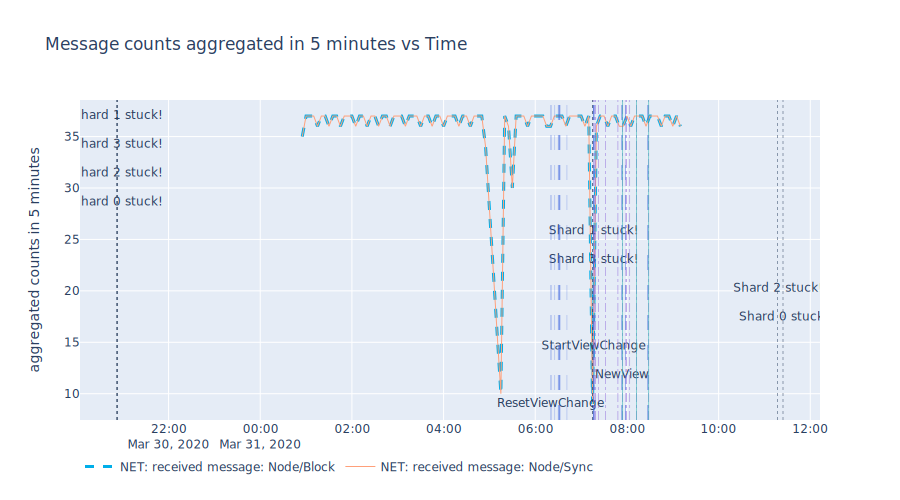

In [12]:
draw_message(agg, alert, viewchange, 5, 'message')